In [20]:
import glob
import re

INPUT_FOLDER = '../../../travelogues-corpus/17th_century/books'

def read_file(f):
  with open(f, 'r') as file:
    str = file.read()
    ascii_only = re.sub('[^A-Za-z0-9 ]+', '', str)
    return re.sub('\\s+', ' ', ascii_only)

# List names of all .txt files in the folder
filenames = [f for f in glob.glob(INPUT_FOLDER + '**/*.txt')]
documents = [ { 'filename': f, 'text': read_file(f) } for f in filenames ]

f'Loaded {len(documents)} documents'

'Loaded 204 documents'

In [21]:
import string
import gensim

texts_cleaned = [ d['text'].translate(str.maketrans('', '', string.punctuation)).lower() for d in documents ]
training_data = [ gensim.models.doc2vec.TaggedDocument(txt.split(), [ i ]) for i, txt in enumerate(texts_cleaned) ]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(training_data)
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [34]:
from sklearn.cluster import KMeans
import numpy as np

vectors = [ model.docvecs[idx] for idx in range(0, len(documents)) ]

km = KMeans(
  n_clusters=5, init='random',
  n_init=10, max_iter=300, 
  tol=1e-04, random_state=0)

km_10_clusters = km.fit_predict(vectors)

In [32]:
from sklearn.manifold import TSNE

tsne_model_2d = TSNE(perplexity=12, n_components=2, init='pca', n_iter=4000, random_state=32)
embeddings_2d = tsne_model_2d.fit_transform(np.array(vectors))

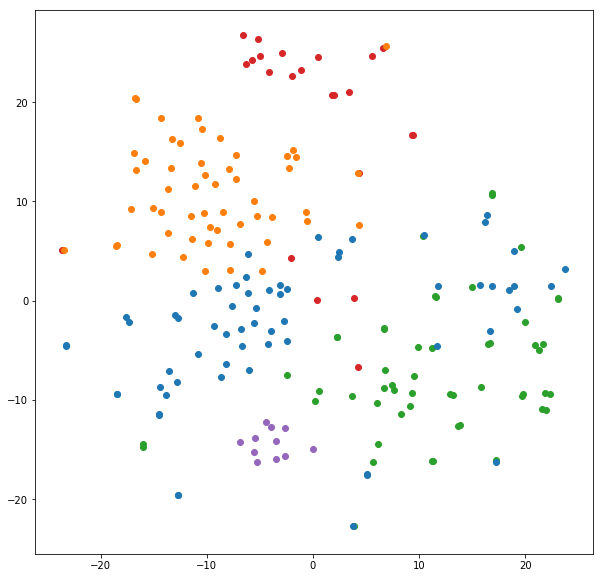

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

colors = cm.tab10_r(np.linspace(0, 1, 10))

clusters = [ embeddings_2d[km_10_clusters == idx] for idx in range(10) ]
clusters = sorted(clusters, key=len)

fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig)

for idx, c in enumerate(clusters):
  x = c[:, 0]
  y = c[:, 1]
  # z = c[:, 2]

  plt.scatter(x, y, s=36, color=colors[idx])

plt.show()

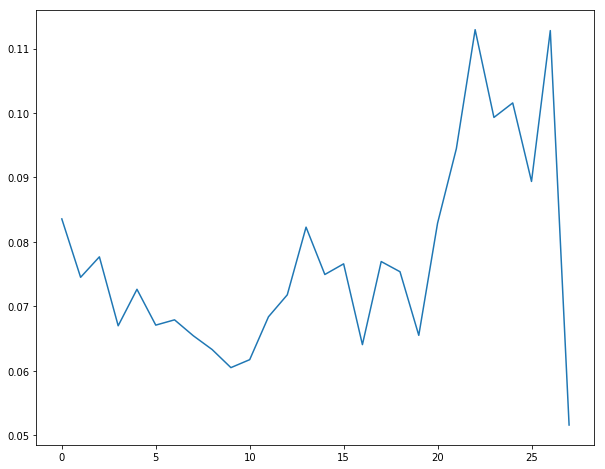

In [38]:
from sklearn.metrics import silhouette_score

sil = []
k_max = 30

for k in range(2, k_max):
  kmeans = KMeans(n_clusters = k).fit(vectors)
  labels = kmeans.labels_
  sil.append(silhouette_score(vectors, labels, metric = 'euclidean'))

plt.figure(figsize=(10, 8))
plt.plot(sil)
plt.show()